### Import

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import random

import sklearn
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from datetime import datetime
% matplotlib inline
import seaborn as sns

import keras
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Input,  Conv1D, GlobalMaxPool1D, concatenate, MaxPooling1D, Flatten
from keras.layers import  Dot, Reshape, multiply, average, add, AveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import metrics

from tqdm import tqdm_notebook as tqdm

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
pip install keras-hypetune

In [ ]:
import kerashypetune
from kerashypetune import KerasGridSearch, KerasRandomSearch

In [ ]:
data = drive.CreateFile({'id': 'here provide the file id from link sharing in your google drive'})
data.GetContentFile('data_preprocessed.pkl')

file = open('data_preprocessed.pkl','rb')
df = pickle.load(file)
print(df.shape)

(1219746, 24)


In [ ]:
df_train = df[df['data_split'] == 'train']
df_test = df[df['data_split'] == 'test']

## Model

### Get model features

In [ ]:
df_train['week'] = df_train['week'].astype('int')
df_train['product_id'] = df_train['product_id'].astype('int')
df_train['user_id'] = df_train['user_id'].astype('int')

df_test['week'] = df_test['week'].astype('int')
df_test['product_id'] = df_test['product_id'].astype('int')
df_test['user_id'] = df_test['user_id'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_padded = np.asarray([df_train['30_day_purchase_history'].tolist()], dtype=int)
train_padded = np.squeeze(train_padded, 0)

test_padded = np.asarray([df_test['30_day_purchase_history'].tolist()], dtype=float)
test_padded = np.squeeze(test_padded, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
embedding_size = 100 
user_len = max(df['user_id'].astype(int)) + 1
item_len = max(df['product_id'].astype(int)) + 1
week_len = max(df['week'].astype(int)) + 1
subcat_len = max(df['subcategory_name'].astype('int')) + 1

## pretrained embeddings

### word2vec

In [ ]:
word2vec_vecs = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
word2vec_vecs.GetContentFile('word_vectors_saved.pkl')

file = open('word_vectors_saved.pkl','rb')
word_vectors_large = pickle.load(file)

In [ ]:
# get product attributes data
products = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
products.GetContentFile('product_attributes_data.tsv.gz')
products = pd.read_table('product_attributes_data.tsv.gz')

products_rpid = products[['article_text', 'rpid']].drop_duplicates()
df = pd.merge(df, products_rpid, how='left', on=['article_text'])

In [ ]:
word_vectors = word_vectors_large
word2vec_vocabs = list(word_vectors_large.vocab)
df['product_id'] = df['product_id'].astype('str')
keys = df['product_id_notenc'].unique().tolist()
values = df['product_id'].astype('int').unique().tolist()
word_dictionary = dict(zip(keys, values))

emb=100
pretrained_weights_products = np.zeros((max(df['product_id'].astype('int')) + 1, emb))
for word, i in word_dictionary.items():
  if word in word2vec_vocabs:
    embedding_vector = word_vectors[word]
    pretrained_weights_products[i] = embedding_vector

### user2vec

In [ ]:
df_train['product_id'] = df_train['product_id'].astype('str')
df_train['user_id'] = df_train['user_id'].astype('str')
only_bought = df_train[df_train['bought'] == 1]

train_products = only_bought[['user_id', 'product_id']]
train_products['new_col'] = train_products.groupby("user_id").transform(lambda x: ','.join(x))
del train_products['product_id']
train_products= train_products.drop_duplicates()

def tagged_document(df):
    #tagging documents
    for index, row in train_products.iterrows():
        yield gensim.models.doc2vec.TaggedDocument(row['new_col'].split(), [row['user_id']])


data_for_training = list(tagged_document(train_products[['user_id', 'new_col']]))

my_model = Doc2Vec(vector_size=100, min_count=1, epochs=100, dm=0, window=35)
my_model.build_vocab(data_for_training)
my_model.train(data_for_training, total_examples=my_model.corpus_count, epochs=100)
pretrained_user_weights = my_model.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [ ]:
word_vectors = my_model.docvecs
word2vec_vocabs = list(my_model.docvecs.index2entity)

df['user_id'] = df['user_id'].astype('str')
keys = df['user_id'].unique().tolist()
values = df['user_id'].astype('int').unique().tolist()
word_dictionary = dict(zip(keys, values))

emb=100
pretrained_user_weights = np.zeros((max(df['user_id'].astype('int')) + 1, emb))
for word, i in word_dictionary.items():
  if word in word2vec_vocabs:
    embedding_vector = word_vectors[word]
    pretrained_user_weights[i] = embedding_vector

df_train['product_id'] = df_train['product_id'].astype('int')
df_train['user_id'] = df_train['user_id'].astype('int')

## Model arch

In [ ]:
#multiple input model
discount = Input(shape=(1,), name='discount')
price = Input(shape=(1,), name='price')
diffs = Input(shape=(1,), name='diffs')

product = Input(shape = (1,), name='product')
product_emb = Embedding(name = 'product_emb', input_dim = item_len, output_dim = 100,
                          embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                          trainable=True
                        )(product)
product_emb = Flatten()(product_emb)

user = Input(shape = (1,), name='user')
user_emb = Embedding(name = 'user_emb',  input_dim = user_len,  output_dim = 100,
                          embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                          trainable=True
                     )(user)
user_emb = Flatten()(user_emb)

week = Input(shape = (1,), name='week')
week_emb = Embedding(name = 'week_emb', input_dim = week_len, output_dim = 100)(week)
week_emb = Flatten()(week_emb)

subcategory = Input(shape=(1,), name='subcategory')
subcategory_emb = Embedding(name = 'subcategory_emb', input_dim = subcat_len, output_dim = 100)(subcategory)
subcategory_emb = Flatten()(subcategory_emb)

purchase_history = Input(shape=(30,1), name='purchase_history')
conv_out = Conv1D(filters=64, kernel_size=2, activation='relu')(purchase_history)
conv_out = AveragePooling1D(pool_size=4, strides=1)(conv_out)
conv_out = Flatten()(conv_out)

x = concatenate([discount, price, diffs, product_emb, user_emb, week_emb, subcategory_emb, conv_out])
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[discount, price, diffs, product, user, week, subcategory, purchase_history], outputs=[x])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
purchase_history (InputLayer)   [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
product (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
week (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

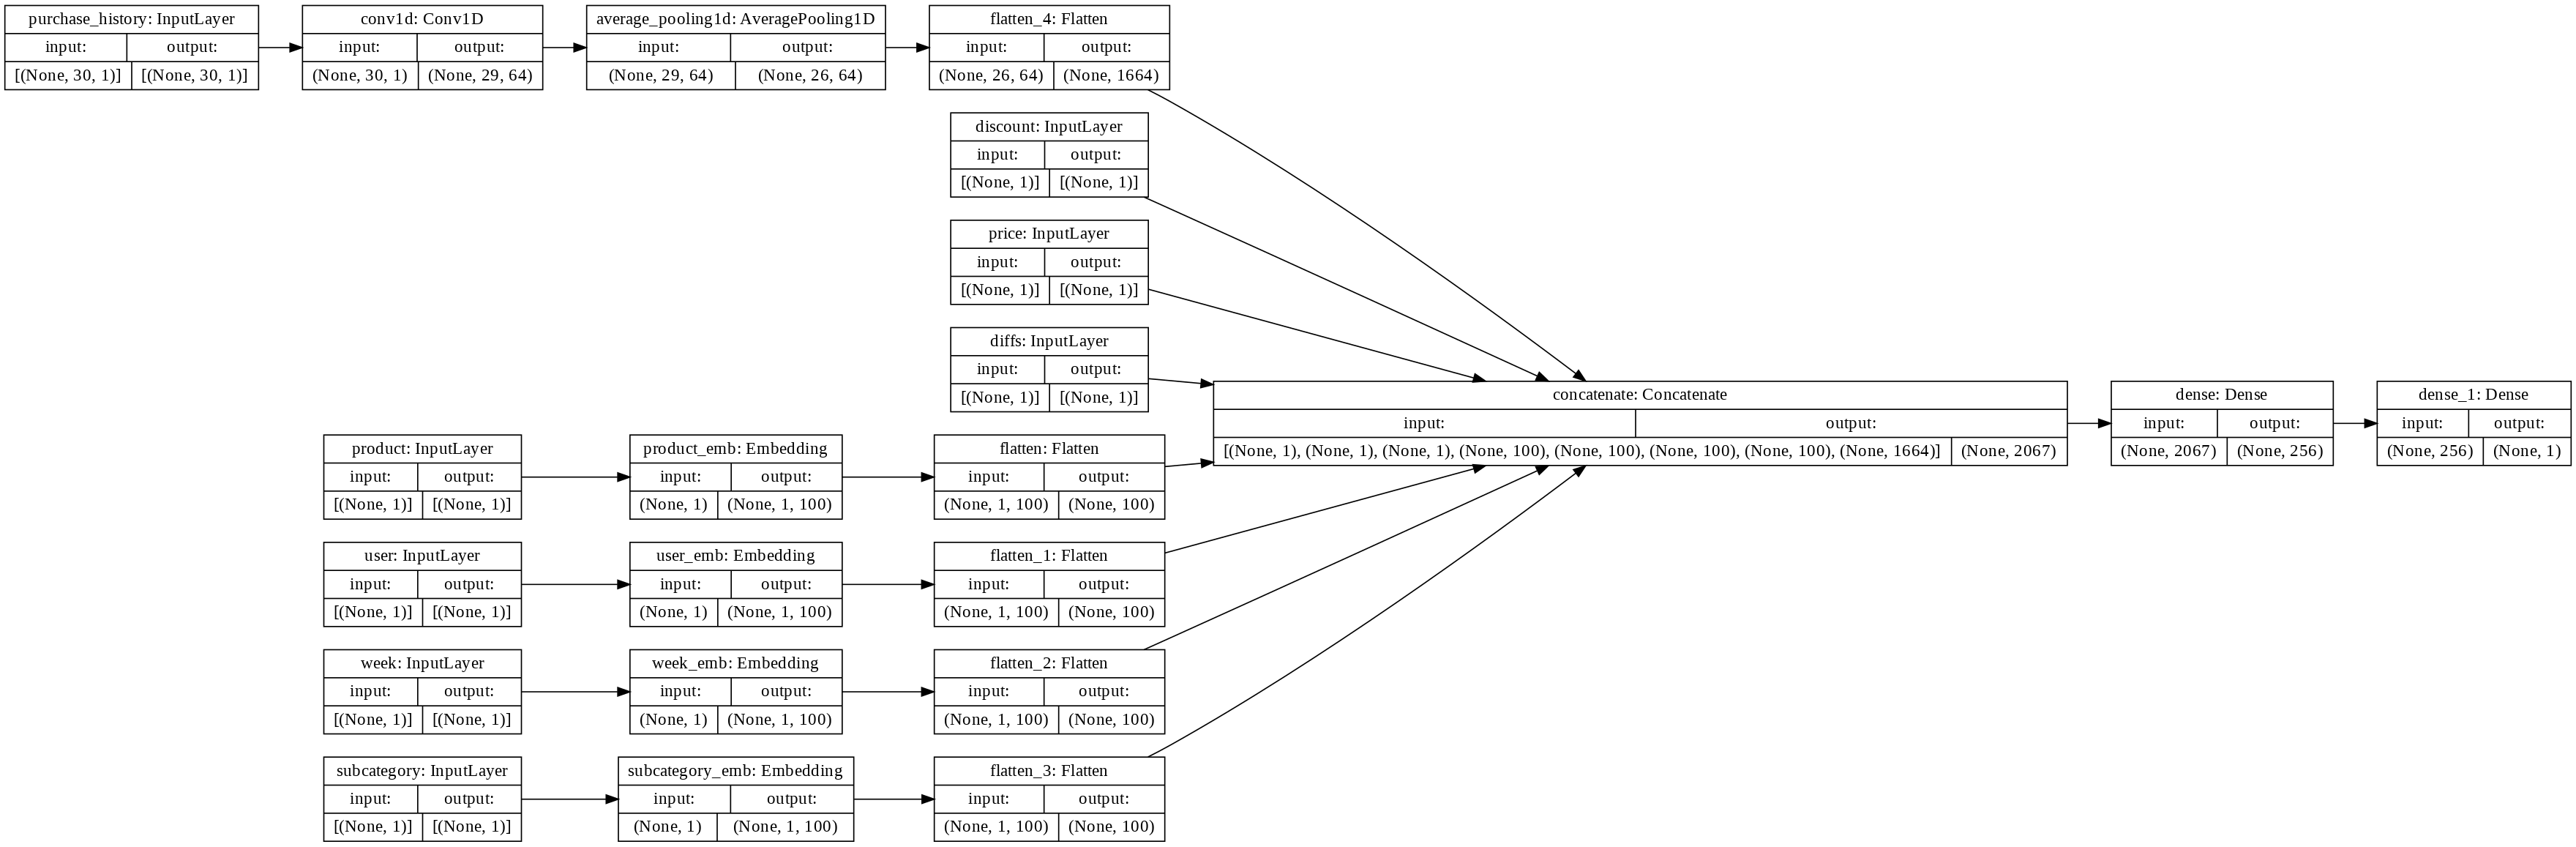

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=True, rankdir='LR',
    show_layer_names=True, dpi=120)

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy()])

early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)

history = model.fit([df_train['discount'], df_train['price'], df_train['diffs'],
                     df_train['product_id'], df_train['user_id'],
                     df_train['week'], df_train['subcategory_name'],
                     train_padded], df_train['bought'],
                     
                    validation_data=([df_test['discount'], df_test['price'], df_test['diffs'],
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'], df_test['subcategory_name'],
                     test_padded], df_test['bought']),
                    
                    batch_size=512, epochs=200,
                    callbacks=[early])

Epoch 1/200
2352/2352 [==============================] - 41s 11ms/step - loss: 0.4815 - auc: 0.8402 - binary_accuracy: 0.7633 - val_loss: 0.4828 - val_auc: 0.8478 - val_binary_accuracy: 0.7719
Epoch 2/200
2352/2352 [==============================] - 24s 10ms/step - loss: 0.4243 - auc: 0.8824 - binary_accuracy: 0.7990 - val_loss: 0.4726 - val_auc: 0.8559 - val_binary_accuracy: 0.7792
Epoch 3/200
2352/2352 [==============================] - 24s 10ms/step - loss: 0.4038 - auc: 0.8951 - binary_accuracy: 0.8110 - val_loss: 0.4675 - val_auc: 0.8606 - val_binary_accuracy: 0.7804
Epoch 4/200
2352/2352 [==============================] - 24s 10ms/step - loss: 0.3899 - auc: 0.9031 - binary_accuracy: 0.8196 - val_loss: 0.4673 - val_auc: 0.8622 - val_binary_accuracy: 0.7813
Epoch 5/200
2352/2352 [==============================] - 24s 10ms/step - loss: 0.3776 - auc: 0.9097 - binary_accuracy: 0.8256 - val_loss: 0.4682 - val_auc: 0.8630 - val_binary_accuracy: 0.7826
Epoch 6/200
2352/2352 [============

## Evaluation

In [ ]:
predictions = model.predict([df_test['discount'], df_test['price'], df_test['diffs'],
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'], df_test['subcategory_name'],
                     test_padded])
df_test['pred_proba']  = predictions
predictions_x = np.where(predictions > 0.5, 1, 0)
df_test['pred'] = predictions_x

0.863865656857684


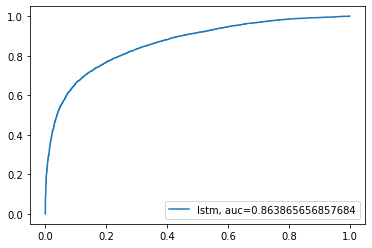

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="lstm, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.7960720525332852,
  'precision': 0.7626688214244488,
  'recall': 0.8325352822580645,
  'support': 7936},
 '1': {'f1-score': 0.7764938923737207,
  'precision': 0.8156471077819393,
  'recall': 0.7409274193548387,
  'support': 7936},
 'accuracy': 0.7867313508064516,
 'macro avg': {'f1-score': 0.786282972453503,
  'precision': 0.7891579646031941,
  'recall': 0.7867313508064516,
  'support': 15872},
 'weighted avg': {'f1-score': 0.7862829724535029,
  'precision': 0.7891579646031941,
  'recall': 0.7867313508064516,
  'support': 15872}}

0.6994516722436191


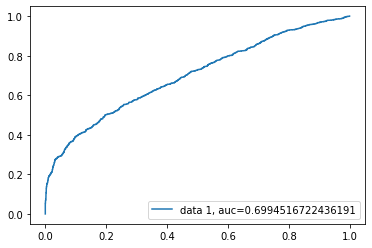

In [ ]:
# weighted AUC
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'], sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], df_test['pred'], sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.5194399351046837,
  'precision': 0.4154762656242871,
  'recall': 0.6927969113445711,
  'support': 233.83115163994572},
 '1': {'f1-score': 0.6837378677491359,
  'precision': 0.8185318412566233,
  'recall': 0.5870618493259406,
  'support': 551.9239419021508},
 'accuracy': 0.6185273167772342,
 'macro avg': {'f1-score': 0.6015889014269098,
  'precision': 0.6170040534404552,
  'recall': 0.6399293803352559,
  'support': 785.7550935420965},
 'weighted avg': {'f1-score': 0.6348448028259033,
  'precision': 0.6985874079343324,
  'recall': 0.6185273167772348,
  'support': 785.7550935420965}}

## Recall@N

In [ ]:
df['user_id'] = df['user_id'].astype('int')
df['product_id'] = df['product_id'].astype('int')
df['week'] = df['week'].astype('int')

In [ ]:
all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))

In [ ]:
for user_id in all_users:
  max_date = max(df[df['user_id'] == user_id]['day'])
  df_train = df[(df['user_id'] == user_id) & (df['data_split'] == 'train')]
  df_train = df_train[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split', 'sample_weight']]
  df_test = df[(df['user_id'] == user_id) & (df['bought'] == 1) & (df['day'] == max_date)]
  df_test = df_test[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split', 'sample_weight']]
  bought_products = df_test['product_id'].unique()

  df_day = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_day = df_day.groupby(['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear'], as_index=False).aggregate({
      'price' : 'first',
      'discount': 'first',
      'diffs' : 'first',
  })
  df_day = df_day.loc[~df_day['product_id'].isin(bought_products)]
  df_day['bought'] = 0
  df_day['data_split'] = 'test'

  df_test = df_test.append(df_day)

  train = df_train.append(df_test)
  train['user_id'] = user_id
  train['day'] = train['day'].astype('str')

  bought_df = train[train['bought'] == 1]
  purchase_history = bought_df.groupby(['product_id', 'user_id'], as_index=False).aggregate({'day' : 'unique'})
  purchase_history.rename(columns={'day' : 'purchase_history'}, inplace=True)
  # merge with actual df
  train = pd.merge(train, purchase_history, how='left', on=['user_id', 'product_id'])

  user_history = bought_df.groupby(['user_id'], as_index=False).aggregate({'day' : 'unique'})
  user_history.rename(columns={'day' : 'user_history'}, inplace=True)
  user_history['user_history'] = user_history['user_history'].map(lambda x: np.sort(x))
  train = pd.merge(train, user_history, how='left', on=['user_id'])

  train['user_history'] = train['user_history'].map(lambda x: [int(i) for i in x])

  train['user_history'] = train['user_history'].map(lambda x: np.sort(x))

  train['day'] = train['day'].astype('int')

  def get_last_30(seq, value):
      lst = []
      for s in seq:
          if s < value:
              lst.append(s)
      return lst[-30:]

  train['last_30_purchase_days'] = train.apply(lambda x: get_last_30(x.user_history, x.day), axis=1)
  train['purchase_history'] = np.where(train['purchase_history'].isna(), "", train['purchase_history'])
  train['purchase_history'] = train['purchase_history'].map(lambda x: [int(i) for i in x])
  train['purchase_history'] = train['purchase_history'].map(lambda x: np.sort(x))

  train['purchase_history'] = train['purchase_history'].map(lambda x: [str(i) for i in x])
  train['last_30_purchase_days'] = train['last_30_purchase_days'].map(lambda x: [str(i) for i in x])
  train['30_day_purchase_history'] = train.apply(lambda x: [1 if str(i) in x.purchase_history else -1 for i in x.last_30_purchase_days], axis=1)
  padded_window_30 = pad_sequences(train['30_day_purchase_history'],30,padding='pre')
  train['30_day_purchase_history'] = padded_window_30.tolist()

  df_test = train[(train['data_split'] == 'test')]
  test_padded = np.asarray([df_test['30_day_purchase_history'].tolist()], dtype=float)
  test_padded = np.squeeze(test_padded, 0)
  df_test['week'] = df_test['week'].astype('int')
  predictions = model.predict([df_test['discount'], df_test['price'], df_test['diffs'],
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'], df_test['subcategory_name'],
                     test_padded])
              
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')
  
  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])
  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])

In [ ]:
pd.DataFrame(recall_matrix)[1].mean()

39.86900696460782

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean() #recall@n weighted

33.48299339697315

In [ ]:
recall_matrix_df = pd.DataFrame(recall_matrix)
recall_matrix_weighted_df = pd.DataFrame(recall_matrix_weighted)

In [ ]:
recall_matrix_df.rename(columns=({0: 'user_id'}), inplace=True)
recall_matrix_weighted_df.rename(columns=({0: 'user_id'}), inplace=True)

In [ ]:
df['user_id'] = df['user_id'].astype('int')
df_visit = df.groupby('user_id', as_index=False).aggregate({'day': 'nunique'}).sort_values(by='day')
df_visit.rename(columns=({'day': 'total_visits'}), inplace=True)

In [ ]:
recall_matrix_df = pd.merge(recall_matrix_df, df_visit, how='left', on=['user_id'])
recall_matrix_weighted_df = pd.merge(recall_matrix_weighted_df, df_visit, how='left', on=['user_id'])

In [ ]:
recalln = [recall_matrix_df[recall_matrix_df['day'] > 45][1].mean(), recall_matrix_df[recall_matrix_df['day'] > 60][1].mean(), recall_matrix_df[recall_matrix_df['day'] > 100][1].mean()]
recalln_adjusted = [recall_matrix_weighted_df[recall_matrix_weighted_df['day'] > 45][1].mean(), recall_matrix_weighted_df[recall_matrix_weighted_df['day'] > 60][1].mean(), recall_matrix_weighted_df[recall_matrix_weighted_df['day'] > 100][1].mean()]

In [ ]:
recall_users = pd.DataFrame([recalln, recalln_adjusted])
recall_users.rename(index={0: "recall@n", 1: "weighted recall@n"}, inplace=True)
recall_users.rename(columns=({0: 'bi_weekly', 1: 'every_10_day', 2: 'weekly'}), inplace=True)

recall_users2 = recall_users.stack().reset_index()
recall_users2.rename(columns=({'level_0' : 'metric', 'level_1' : 'user visits', 0: 'value'}), inplace=True)

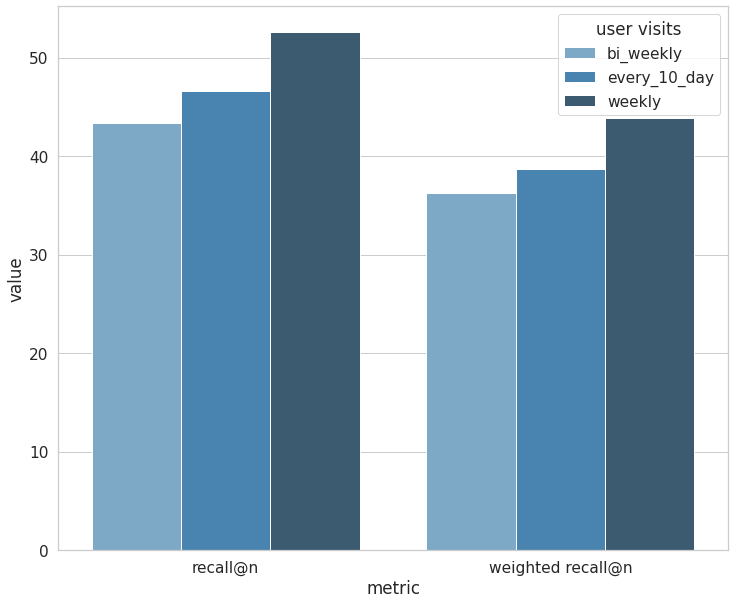

In [ ]:
sns.set(font_scale=1.4, style="whitegrid") 
plt.figure(figsize=(12, 10))
sns.barplot(data=recall_users2, x ="metric", y="value", hue="user visits",  palette="Blues_d")
plt.show()

## Grid search

In [ ]:
def get_model(param):
    discount = Input(shape=(1,), name='discount')
    price = Input(shape=(1,), name='price')
    diffs = Input(shape=(1,), name='diffs')

    product = Input(shape = (1,), name='product')
    product_emb = Embedding(name = 'product_emb', input_dim = item_len, output_dim = 100)(product)
    product_emb = Flatten()(product_emb)

    user = Input(shape = (1,), name='user')
    user_emb = Embedding(name = 'user_emb',  input_dim = user_len,  output_dim = 100)(user)
    user_emb = Flatten()(user_emb)

    week = Input(shape = (1,), name='week')
    week_emb = Embedding(name = 'week_emb', input_dim = week_len, output_dim = 100)(week)
    week_emb = Flatten()(week_emb)

    subcategory = Input(shape=(1,), name='subcategory')
    subcategory_emb = Embedding(name = 'subcategory_emb', input_dim = subcat_len, output_dim = 100)(subcategory)
    subcategory_emb = Flatten()(subcategory_emb)

    purchase_history = Input(shape=(30,1), name='purchase_history')
    conv_out = Conv1D(filters=param['cnn_filters'], kernel_size=2, activation='relu')(purchase_history)
    conv_out = MaxPooling1D(pool_size=param['pool_size'], strides=param['strides'])(conv_out)
    conv_out = Flatten()(conv_out)

    x = concatenate([discount, price, diffs, product_emb, user_emb, week_emb, subcategory_emb, conv_out])
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[discount, price, diffs, product, user, week, subcategory, purchase_history], outputs=[x])
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=param['lr']),
                  metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy()]) 
    return model

In [ ]:
param_grid = {
    'cnn_filters' : [8, 16, 64],
    'pool_size' : [2, 3],
    'strides' : [1, 2],
    'lr': [1e-3, 1e-4, 1e-5],
    'epochs': 200, 
    'batch_size': [512, 1024, 2048]
}
early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
kgs = KerasRandomSearch(get_model, param_grid, monitor='val_binary_accuracy', greater_is_better=True, n_iter=36)

In [ ]:
kgs.search([df_train['discount'], df_train['price'], df_train['diffs'],
                     df_train['product_id'], df_train['user_id'],
                     df_train['week'], df_train['subcategory_name'],
                     train_padded], df_train['bought'],
                     
                    validation_data=([df_test['discount'], df_test['price'], df_test['diffs'],
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'], df_test['subcategory_name'],
                     test_padded], df_test['bought']), callbacks=[early]
          )


36 trials detected for ('cnn_filters', 'pool_size', 'strides', 'lr', 'epochs', 'batch_size')

***** (1/36) *****
Search({'cnn_filters': 8, 'pool_size': 2, 'strides': 2, 'lr': 0.001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.77457 at epoch 13

***** (2/36) *****
Search({'cnn_filters': 64, 'pool_size': 2, 'strides': 1, 'lr': 1e-05, 'epochs': 200, 'batch_size': 512})
SCORE: 0.75977 at epoch 18

***** (3/36) *****
Search({'cnn_filters': 64, 'pool_size': 3, 'strides': 2, 'lr': 0.0001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.77634 at epoch 14

***** (4/36) *****
Search({'cnn_filters': 64, 'pool_size': 3, 'strides': 1, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.78037 at epoch 6

***** (5/36) *****
Search({'cnn_filters': 8, 'pool_size': 2, 'strides': 1, 'lr': 0.001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.77715 at epoch 7

***** (6/36) *****
Search({'cnn_filters': 8, 'pool_size': 3, 'strides': 2, 'lr': 0.0001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.77243 at ep

## Calculate elasticity

In [ ]:
products.rename(columns=({'category_name' : 'category_identification'}), inplace=True)
df_categories = pd.merge(df_categories, products, how='left', on='article_text')

df_categories = df_categories[['category_name', 'category_identification']]

In [ ]:
seed_integers = random.sample(range(1, 1000), 1)
epsilon = 1.e-35
discount = 0.30

In [ ]:
elasticity_item_bin = pd.DataFrame()
elasticity_category = pd.DataFrame()
elasticity_all = pd.DataFrame()

for i in seed_integers:

  #randomly select 500 product_index
  from sklearn.model_selection import train_test_split, GroupShuffleSplit
  train_inds, test_inds = next(GroupShuffleSplit(test_size=500, n_splits=2, random_state =i).split(df_test, groups=df_test['product_index']))
  single_product = df_test.iloc[test_inds]

  single_product_purchases = single_product[['product_id', 'total_purchases']].drop_duplicates()
  single_product_purchases['item_bin'] = single_product.total_purchases.apply(lambda x: 'blockbusters' if x > 104 else ('middle_products' if 104 >= x > 38 else 'long_tail'))
  single_product_purchases = single_product_purchases[['product_id', 'item_bin']]
  single_product_purchases.rename(columns=({'product_id' : 'product_interest'}), inplace=True)

  # before price changes
  test_padded_single_product = np.asarray([single_product['30_day_purchase_history'].tolist()], dtype=float)
  test_padded_single_product = np.squeeze(test_padded_single_product, 0)


  predictions = model.predict([single_product['discount'],
                      single_product['price'], 
                      single_product['diffs'], 
                      single_product['product_id'], single_product['user_id'],
                      single_product['week'],  single_product['subcategory_name']
                      ,test_padded_single_product])
  single_product['predictions'] = predictions
  single_product['predictions'] = np.where(single_product['predictions'] == 0, single_product['predictions'] + epsilon, single_product['predictions'])

  all_products = single_product['product_id'].unique().tolist()
  tqdm().pandas()
  for product_id in tqdm(all_products):
    # after price changes
    single_product_adaptive = single_product.copy(deep=True)
    single_product_adaptive.loc[single_product_adaptive.product_id == product_id, ['price']] = single_product_adaptive[single_product_adaptive['product_id'] == product_id]['price']*(1-discount)
    # change discount
    single_product_adaptive.loc[single_product_adaptive.product_id == product_id, ['new_discount']] = 1-((1-single_product_adaptive[single_product_adaptive['product_id'] == product_id]['discount'])*(1- discount))
    # change cross product discount diff
    for product_index in single_product_adaptive[single_product_adaptive['product_id'] == product_id]['product_index'].tolist():
      discount_difference = single_product_adaptive[(single_product_adaptive['product_index'] == product_index) &(single_product_adaptive['product_id'] == product_id)][['discount', 'new_discount']].diff(axis=1)['new_discount']
      single_product_adaptive.loc[(single_product_adaptive.product_id != product_id) & (single_product_adaptive['product_index'] == product_index) , ['diffs']] = (single_product_adaptive[(single_product_adaptive.product_id != product_id) & (single_product_adaptive['product_index'] == product_index)]['diffs']) - np.array(discount_difference)
      single_product_adaptive.loc[(single_product_adaptive.product_id == product_id) & (single_product_adaptive['product_index'] == product_index) , ['diffs']] = (single_product_adaptive[(single_product_adaptive.product_id == product_id) & (single_product_adaptive['product_index'] == product_index)]['diffs']) + np.array(discount_difference)

    single_product_adaptive['discount'] = np.where(single_product_adaptive['product_id'] == product_id, single_product_adaptive['new_discount'], single_product_adaptive['discount'])
    
    test_padded_single_product = np.asarray([single_product_adaptive['30_day_purchase_history'].tolist()], dtype=float)
    test_padded_single_product = np.squeeze(test_padded_single_product, 0)


    globals()['string%s' % product_id] = model.predict([
                      single_product_adaptive['discount'],
                      single_product_adaptive['price'], 
                      single_product_adaptive['diffs'], 
                      single_product_adaptive['product_id'], single_product_adaptive['user_id'],
                      single_product_adaptive['week'],  single_product_adaptive['subcategory_name']
                      ,test_padded_single_product
                      ])

    single_product['predictions_'+str(product_id)] = globals()['string%s' % product_id]
    single_product['predictions_'+str(product_id)] = np.where(single_product['predictions_'+str(product_id)] == 0, single_product['predictions_'+str(product_id)] + epsilon, single_product['predictions_'+str(product_id)])

  product_indices = single_product.groupby("product_index", as_index=False).aggregate({'product_id': 'unique'})
  product_indices.rename(columns=({'product_id' : 'product_indices'}), inplace=True)
  single_product = pd.merge(single_product, product_indices, how='left', on=['product_index'])

  for product_id in all_products:
    single_product['predictions_'+str(product_id)] = (single_product['predictions_'+str(product_id)] - single_product['predictions'])/(single_product['predictions'] * discount*(-1))

  columns = ['new_column', 'product_interest']
  df_new = pd.DataFrame(columns=columns)

  for product_id in tqdm(all_products):
    single_product_adaptive = single_product.copy(deep=True)
    single_product_adaptive['new_column'] = single_product_adaptive.apply(lambda x: 'own_price_effect' if product_id in x.product_indices and product_id==x.product_id else ('cross_price_effect' if product_id in x.product_indices and product_id!=x.product_id else 0), axis=1)
    single_product_adaptive = single_product_adaptive[single_product_adaptive['new_column'] != 0]
    #this is where I group by for users
    single_product_adaptive = single_product_adaptive.groupby('new_column', as_index=False).agg(Mean_elasticity=('predictions_'+str(product_id), 'mean'), Median_elasticity=('predictions_'+str(product_id), 'median'), Stdeviation=('predictions_'+str(product_id), 'std'),  count_elasticity=('predictions_'+str(product_id), 'count'))

    single_product_adaptive['product_interest'] = product_id
    df_new = df_new.append(single_product_adaptive)
  df_new = pd.merge(df_new, single_product_purchases, how='left', on='product_interest')
  category_and_subcategory = single_product[['product_id', 'category_name', 'subcategory_name']].drop_duplicates()
  category_and_subcategory.rename(columns=({'product_id' : 'product_interest'}), inplace=True)
  df_new = pd.merge(df_new, category_and_subcategory, how='left', on='product_interest')

  df_new = df_new.sort_values(by='Mean_elasticity')
  elasticity_item_bin = elasticity_item_bin.append(df_new.groupby(['new_column', 'item_bin'], as_index=False).aggregate({'Mean_elasticity' : 'mean'}))
  elasticity_category = elasticity_category.append(df_new.groupby(['new_column', 'category_name'], as_index=False).aggregate({'Mean_elasticity' : 'mean'}))

In [ ]:
selected_categories = ["milk", "vegetables", "fruit", "yogurt_cream_cheese", "cheese", "meat_sausages", "bread","soft drinks", "beer", "water"]
elasticity_category = pd.merge(elasticity_category, df_categories, how='left', on='category_name')


In [ ]:
print(elasticity_category[elasticity_category['new_column'] == "own_price_effect"].groupby(['new_column', 'category_identification'], as_index=False).aggregate({'Mean_elasticity' : 'mean'}).sort_values(by=['Mean_elasticity']).head(10))

          new_column category_identification  Mean_elasticity
38  own_price_effect       frozen_vegetables       -24.925114
48  own_price_effect               oral_care       -11.205380
29  own_price_effect               detergent        -8.161674
41  own_price_effect               hair_care        -5.829085
52  own_price_effect             rice_grains        -3.800523
15  own_price_effect          chocolate_bars        -3.412001
66  own_price_effect              vegetables        -3.001307
37  own_price_effect          frozen_poultry        -2.662535
62  own_price_effect                   sugar        -2.660286
19  own_price_effect                  coffee        -2.108788


In [ ]:
print(elasticity_category[elasticity_category['category_identification'].isin(selected_categories)].groupby(['new_column', 'category_identification'], as_index=False).aggregate({'Mean_elasticity' : 'mean'}).sort_values(by=['Mean_elasticity']).head(20))

            new_column category_identification  Mean_elasticity
13    own_price_effect              vegetables        -3.001307
12    own_price_effect                    milk        -2.056996
15    own_price_effect     yogurt_cream_cheese        -1.299557
7   cross_price_effect     yogurt_cream_cheese        -0.763093
11    own_price_effect           meat_sausages        -0.717186
10    own_price_effect                  cheese        -0.611404
3   cross_price_effect           meat_sausages        -0.488066
14    own_price_effect                   water        -0.459156
2   cross_price_effect                  cheese        -0.431634
1   cross_price_effect                   bread        -0.386867
9     own_price_effect                   bread        -0.203955
0   cross_price_effect                    beer        -0.184265
4   cross_price_effect                    milk        -0.011064
6   cross_price_effect                   water         0.241420
8     own_price_effect                  

In [ ]:
print(elasticity_item_bin.groupby(['new_column', 'item_bin'], as_index=False).aggregate({'Mean_elasticity' : 'mean'}))

           new_column         item_bin  Mean_elasticity
0  cross_price_effect     blockbusters         0.096616
1  cross_price_effect        long_tail        -0.296352
2  cross_price_effect  middle_products        -0.117806
3    own_price_effect     blockbusters        -0.631219
4    own_price_effect        long_tail        -2.202860
5    own_price_effect  middle_products        -1.159845
